# Visualization

Nov 10th / Yuqi

## 1 Import

In [227]:
from plot_helpers import *
from data_helpers import *
from decomp import *

import os, sys, gzip, json
from pathlib import Path
from sortedcontainers import SortedList, SortedDict
from loguru import logger
import pandas as pd
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from IPython.display import JSON
import ijson
import seaborn as sns

%load_ext autoreload
%autoreload 2

sns.set_theme(style='darkgrid')  # Options include 'darkgrid', 'whitegrid', 'dark', 'white', and 'ticks'
sns.set()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [228]:
# Remove default handler
logger.remove()
# Add a new handler with level WARNING
logger.add(sys.stdout, level="ERROR")

18

## 2 Initalize paths

In [229]:
DATASETS_DIR = "./data/"
PLOTS_DIR = "./plots/"
JSON_PATH = "jsons/"

## 3 ```class Meas``` for visualizing single dataset

This block aims to construct a clear and consice way of visualization by code encapsulation.


In [230]:
SKIP_FIRST = 1000
SKIP_LAST = 100
class Meas: 
    class Data:
        def __init__(self, datasets_dir,meas_label):
            """
            Meas.Data: Store the data from one measurement
            """
            self.meas_label = meas_label
            self.data_path = datasets_dir + meas_label
            jsons_path = os.path.join(self.data_path, JSON_PATH)
            self.packets = read_json(os.path.join(jsons_path, "packets.json"))
            self.sr_tx_arr = read_json(os.path.join(jsons_path, "sr_tx.json"))
            self.bsr_tx_arr = read_json(os.path.join(jsons_path, "bsr_tx.json"))
            self.bsrupd_arr = read_json(os.path.join(jsons_path, "bsr_upd.json"))
            self.bsrupd_sorted_dict = SortedDict(
                {bsrupd["timestamp"]: bsrupd for bsrupd in self.bsrupd_arr}
            )
            self.sr_bsr_tx_sorted_list = SortedList(
                [sr_tx["timestamp"] for sr_tx in self.sr_tx_arr]
                + [bsr_tx["timestamp"] for bsr_tx in self.bsr_tx_arr]
            )
            self.sched_arr = read_json(os.path.join(jsons_path, "sched.json"))
            self.sched_sorted_dict = SortedDict(
                {sched["decision_ts"]: sched for sched in self.sched_arr}
            )
            self.packets_rnti_set = set(
                [
                    item["rlc.attempts"][0]["rnti"]
                    for item in self.packets
                    if item["rlc.attempts"][0]["rnti"] != None
                ]
            )
            print(f"RNTIs in packets of {self.meas_label}: {list(self.packets_rnti_set)}")
            self.mcs_arr_all = read_json(os.path.join(jsons_path, "mcs.json"))
            self.tb_arr = read_json(os.path.join(jsons_path, "tb.json"))
            self.set_rnti = set([item["rnti"] for item in self.mcs_arr_all])
            # filter entries with rnti list(packets_rnti_set)[0]
            if list(self.packets_rnti_set)[0] != None:
                self.mcs_arr = [
                    mcs
                    for mcs in self.mcs_arr_all
                    if mcs["rnti"] == list(self.packets_rnti_set)[0]
                ]
            else:
                self.mcs_arr = self.mcs_arr_all
            self.mcs_sorted_dict = SortedDict(
                {mcs["timestamp"]: mcs for mcs in self.mcs_arr}
            )

    class Delays:
        def __init__(self, data):
            """
            Meas.Delays: Calculate and store delay components, utilizing decomp.py
            """
            self.idt = np.array(
                list(
                    {
                        data.packets[ind]["id"]: data.packets[ind]["ip.in_t"]
                        - data.packets[ind - 1]["ip.in_t"]
                        for ind in range(1, len(data.packets))
                        if data.packets[ind]["ip.in_t"] != None
                        and data.packets[ind - 1]["ip.in_t"] != None
                    }.values()
                )
            )
            self.frame_alignment_delays = np.array(
                list(
                    {
                        packet["id"]: get_frame_alignment_delay(
                            packet,
                            data.sr_bsr_tx_sorted_list,
                            slots_per_frame=20,
                            slots_duration_ms=0.5,
                        )
                        for packet in data.packets
                        if get_frame_alignment_delay(
                            packet,
                            data.sr_bsr_tx_sorted_list,
                            slots_per_frame=20,
                            slots_duration_ms=0.5,
                        )
                        != None
                    }.values()
                )
            )
            self.scheduling_delays = np.array(
                list(
                    {
                        packet["id"]: get_scheduling_delay(
                            packet,
                            data.sched_sorted_dict,
                            slots_per_frame=20,
                            slots_duration_ms=0.5,
                        )
                        for packet in data.packets
                        if get_scheduling_delay(
                            packet,
                            data.sched_sorted_dict,
                            slots_per_frame=20,
                            slots_duration_ms=0.5,
                        )
                        != None
                    }.values()
                )
            )
            self.ran_delays = np.array(
                list(
                    {
                        packet["id"]: get_ran_delay(packet)
                        for packet in data.packets
                        if get_ran_delay(packet) != None
                    }.values()
                )
            )
            self.ran_delays_wo_frame_alignment_delay = np.array(
                list(
                    {
                        packet["id"]: get_ran_delay_wo_frame_alignment_delay(
                            packet,
                            data.sr_bsr_tx_sorted_list,
                            slots_per_frame=20,
                            slots_duration_ms=0.5,
                        )
                        for packet in data.packets
                        if get_ran_delay_wo_frame_alignment_delay(
                            packet,
                            data.sr_bsr_tx_sorted_list,
                            slots_per_frame=20,
                            slots_duration_ms=0.5,
                        )
                        != None
                    }.values()
                )
            )
            self.ran_delays_wo_scheduling_delay = np.array(
                list(
                    {
                        packet["id"]: get_ran_delay_wo_scheduling_delay(
                            packet,
                            data.sched_sorted_dict,
                            slots_per_frame=20,
                            slots_duration_ms=0.5,
                        )
                        for packet in data.packets
                        if get_ran_delay_wo_scheduling_delay(
                            packet,
                            data.sched_sorted_dict,
                            slots_per_frame=20,
                            slots_duration_ms=0.5,
                        )
                        != None
                    }.values()
                )
            )
            self.queueing_delays = np.array(
                list(
                    {
                        packet["id"]: get_queueing_delay(packet)
                        for packet in data.packets
                        if get_queueing_delay(packet) != None
                    }.values()
                )
            )
            self.queueing_delays_wo_scheduling_delay = np.array(
                list(
                    {
                        packet["id"]: get_queueing_delay_wo_scheduling_delay(
                            packet,
                            data.sched_sorted_dict,
                            slots_per_frame=20,
                            slots_duration_ms=0.5,
                        )
                        for packet in data.packets
                        if get_queueing_delay_wo_scheduling_delay(
                            packet,
                            data.sched_sorted_dict,
                            slots_per_frame=20,
                            slots_duration_ms=0.5,
                        )
                        != None
                    }.values()
                )
            )
            self.segmentation_delay = np.array(
                list(
                    {
                        packet["id"]: get_segmentation_delay(packet)
                        for packet in data.packets
                        if get_segmentation_delay(packet) != None
                    }.values()
                )
            )
            self.segmentation_delays_wo_scheduling_delay = np.array(
                list(
                    {
                        packet["id"]: get_segmentation_delay_wo_scheduling_delay(
                            packet,
                            data.sched_sorted_dict,
                            slots_per_frame=20,
                            slots_duration_ms=0.5,
                        )
                        for packet in data.packets
                        if get_segmentation_delay_wo_scheduling_delay(
                            packet,
                            data.sched_sorted_dict,
                            slots_per_frame=20,
                            slots_duration_ms=0.5,
                        )
                        != None
                    }.values()
                )
            )
            self.segments = np.array(
                list(
                    {
                        packet["id"]: get_segments(packet)
                        for packet in data.packets
                        if get_segments(packet) != None
                    }.values()
                )
            )
            self.retx_delays = np.array(
                list(
                    {
                        packet["id"]: get_retx_delay(packet)
                        for packet in data.packets
                        if get_retx_delay(packet) != None
                    }.values()
                )
            )
            self.mcss=np.array(
                list(
                    {
                        packet["id"]: get_mcs(
                            packet,
                            data.mcs_sorted_dict,
                            slots_per_frame=20,
                            slots_duration_ms=0.5,
                        )
                        for packet in data.packets
                        if get_mcs(
                            packet,
                            data.mcs_sorted_dict,
                            slots_per_frame=20,
                            slots_duration_ms=0.5,
                        )
                        != None
                    }.values()
                )
            )

    def __init__(self, datasets_dir=DATASETS_DIR, meas_label="s49"):
        """
        Meas: 
            a class which store and analyze 1 group(1 folder) of measurement. The init function utilizes data_helps.py
        Parameters:
            datasets_dir(str): Path of all datasets;
            meas_label(str): The measurement label;
        """
        self.meas_label=meas_label
        self.data=self.Data(datasets_dir, meas_label)
        self.delays=self.Delays(self.data)
        if not os.path.exists(PLOTS_DIR + self.data.meas_label):
            os.makedirs(PLOTS_DIR + self.data.meas_label)

    def checkData(self, name, pkt_idx=0):
        """
        checkData: check the 1st json object of given attribute name

        Parameters:
            name(str): the attribute name of Meas.Delay\
            pkt_idx(int): the index of checked json object
        """
        attr=getattr(self.data, name, None)
        if attr is not None:
            print(json.dumps(attr[pkt_idx], indent=4, allow_nan=True))
        else:
            print(f"No attribute {name} found in Meas_{self.data.meas_label}.data")

    def plotCCDF(self, curve_name,skip_first=SKIP_FIRST, skip_last=SKIP_LAST, figsize=(8,5), plt_show=True, ax_external=None):
        """
        Meas.plotCCDF:
            plot 1 ccdf among 13 kinds of delay measurement

        Parameters:
            curve_name(str):the delay measurement you want to plot
            skip_first(int): skip first a few packets
            skip_last(int):  skip last a few packets
            figsize(tuple):  figsize
            plt_show(bool):  if or not show and save figure.
            ax_external(object): external plot object
        """
        curve=getattr(self.delays, curve_name, None)
        if curve is not None:
            plot_ccdf(curve[skip_first:-skip_last], f"{self.data.meas_label}_{curve_name}", figsize=figsize, ax=ax_external)
            if plt_show:
                plt.tight_layout()
                plt.savefig(f"{PLOTS_DIR}{self.data.meas_label}/{curve_name}_ccdf_plot.png", dpi=300, bbox_inches='tight')
                plt.show()
        else:
            print(f"No attribute {curve_name} found in meas.delays of {self.data.meas_label}.")

    def plotAllCCDF(self, figsize=(24,24),subplot_division=[1,1]):
        """
        Meas.plotAllCCDF:
            plot ccdf for 13 kinds of delay measurement

        Parameters:
            figsize(tuple):  figsize
            subplot_division(list=[x,y]): x-row y-column subplots. If [1,1], figures will be plotted separately.
        """
        curve_names = [
            "idt",
            "frame_alignment_delays",
            "scheduling_delays",
            "ran_delays",
            "ran_delays_wo_frame_alignment_delay",
            "ran_delays_wo_scheduling_delay",
            "queueing_delays",
            "queueing_delays_wo_scheduling_delay",
            "segmentation_delay",
            "segmentation_delays_wo_scheduling_delay",
            "segments",
            "retx_delays",
            "mcss",
        ]
        figure_num=0
        for i in range(0,13):
            if i % (subplot_division[0]*subplot_division[1]) == 0:
                if i != 0:
                    plt.tight_layout()
                    plt.savefig(f"{PLOTS_DIR}{self.data.meas_label}/all_ccdf_plots_{figure_num}.png", dpi=300)
                    figure_num=figure_num+1
                    plt.show()
                _, axs = plt.subplots(subplot_division[0], subplot_division[1], figsize=figsize)

            if subplot_division[0]*subplot_division[1]==1:
                self.plotCCDF(curve_names[i], plt_show=False, ax_external=axs)
            elif subplot_division[0]==1 or subplot_division[1]==1:
                self.plotCCDF(curve_names[i], plt_show=False, ax_external=axs[i % (subplot_division[1]*subplot_division[0])])
            else:
                self.plotCCDF(
                    curve_names[i],
                    plt_show=False,
                    ax_external=axs[
                        (i % (subplot_division[1]*subplot_division[0] ) // subplot_division[1]),
                        i % subplot_division[1],
                    ],
                )
        plt.tight_layout()
        plt.savefig(f"{PLOTS_DIR}{self.data.meas_label}/all_ccdf_plots_{figure_num}.png", dpi=300, bbox_inches="tight")
        plt.show()

    def plotTimeSeries(self, curve_names, curves=None, start_idx=5000, end_idx=6000, figsize=(12,5), marker="*", title="timeseries",plt_show=True, ax_external=None):
        if ax_external is not None:
            ax = ax_external
        else:
            _, ax = plt.subplots(figsize=figsize)
        index_range = slice(start_idx, end_idx)
        for idx,curve_name in enumerate(curve_names):
            if curves is not None:
                ax.plot(curves[idx][index_range], marker=marker, label=f"{self.data.meas_label}: {curve_name}")
            else:
                curve = getattr(self.delays, curve_name, None)
                if curve is not None:
                    ax.plot(curve[index_range], marker=marker, label=f"{self.data.meas_label}: {curve_name}")
                else:
                    print(
                        f"Curve {curve_name} not found in meas.delays of {self.data.meas_label}."
                    )
        ax.set_xlabel("Index")
        ax.set_ylabel("Delay [ms]")
        ax.grid(True,"minor")
        ax.legend()
        if plt_show == True:
            i = 1
            while os.path.exists(os.path.join(PLOTS_DIR, self.data.meas_label, f"{title}_{i}.png")):
                i += 1
            plt.tight_layout()
            plt.savefig(
                f"{PLOTS_DIR}{self.data.meas_label}/{title}_{i}.png", dpi=300, bbox_inches="tight"
            )
            plt.show()
    
    

### 3.1 Usage of ```class Meas``` 

#### 3.1.1 Import dataset

In [231]:
Meas_s49=Meas(meas_label='s49')

RNTIs in packets of s49: ['5fcf']
2024-11-13 13:17:17.967 | ERROR    | decomp:get_tx_delay:164 - Packet 39730 phy.in_t or phy.in_t not present
2024-11-13 13:17:17.967 | ERROR    | decomp:get_tx_delay:164 - Packet 39730 phy.in_t or phy.in_t not present
2024-11-13 13:17:17.969 | ERROR    | decomp:get_tx_delay:164 - Packet 39728 phy.in_t or phy.in_t not present
2024-11-13 13:17:17.969 | ERROR    | decomp:get_tx_delay:164 - Packet 39728 phy.in_t or phy.in_t not present
2024-11-13 13:17:17.999 | ERROR    | decomp:get_tx_delay:164 - Packet 38849 phy.in_t or phy.in_t not present
2024-11-13 13:17:18.000 | ERROR    | decomp:get_tx_delay:164 - Packet 38849 phy.in_t or phy.in_t not present
2024-11-13 13:17:18.004 | ERROR    | decomp:get_tx_delay:164 - Packet 38686 phy.in_t or phy.in_t not present
2024-11-13 13:17:18.007 | ERROR    | decomp:get_tx_delay:164 - Packet 38686 phy.in_t or phy.in_t not present
2024-11-13 13:17:18.010 | ERROR    | decomp:get_tx_delay:164 - Packet 38523 phy.in_t or phy.in

#### 3.1.2 ```checkData``` check dict sctructure
print the [pkt_idx]-th json object in the given Meas.Data attribute name 

Here are all attributes retrieved from json files, stored in [Meas_instance].data

In [232]:
print(list(vars(Meas_s49.data).keys()))  # ['attr1', 'attr2']

['meas_label', 'data_path', 'packets', 'sr_tx_arr', 'bsr_tx_arr', 'bsrupd_arr', 'bsrupd_sorted_dict', 'sr_bsr_tx_sorted_list', 'sched_arr', 'sched_sorted_dict', 'packets_rnti_set', 'mcs_arr_all', 'tb_arr', 'set_rnti', 'mcs_arr', 'mcs_sorted_dict']


In [233]:
Meas_s49.checkData("sched_arr")

{
    "decision_ts": 1730544337.951296,
    "schedule_ts": 1730544337.954296,
    "symbols_start": 10,
    "symbols_num": 3,
    "prbs_start": 0,
    "prbs_num": 5,
    "cause": {
        "rnti": "22a0",
        "tbs": 24,
        "mcs": 9,
        "rbs": 5,
        "type": 3,
        "diff": 7149.0,
        "buf": NaN,
        "sched": NaN,
        "hqround": NaN,
        "hqpid": NaN
    }
}


#### 3.1.3 ```plotCCDF``` plot CCDF of single delay component

In [234]:
print(list(vars(Meas_s49.delays).keys()))  # ['attr1', 'attr2']

['idt', 'frame_alignment_delays', 'scheduling_delays', 'ran_delays', 'ran_delays_wo_frame_alignment_delay', 'ran_delays_wo_scheduling_delay', 'queueing_delays', 'queueing_delays_wo_scheduling_delay', 'segmentation_delay', 'segmentation_delays_wo_scheduling_delay', 'segments', 'retx_delays', 'mcss']


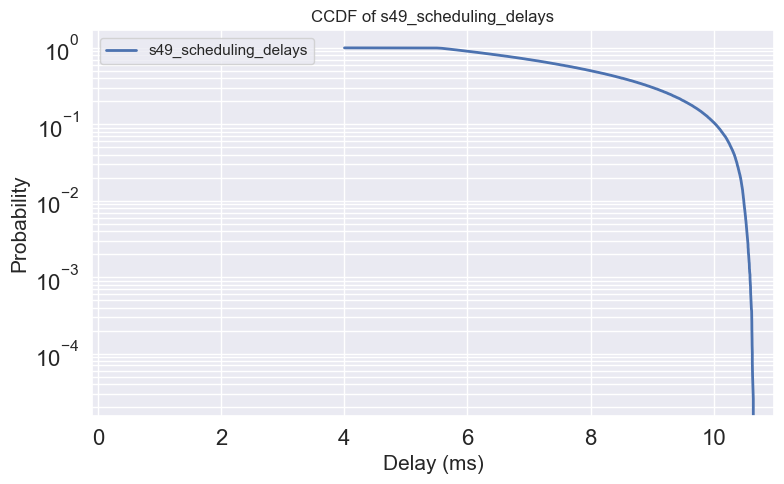

In [235]:
Meas_s49.plotCCDF("scheduling_delays")

#### 3.1.4 ```plotAllCCDF``` plot all CCDF curves 

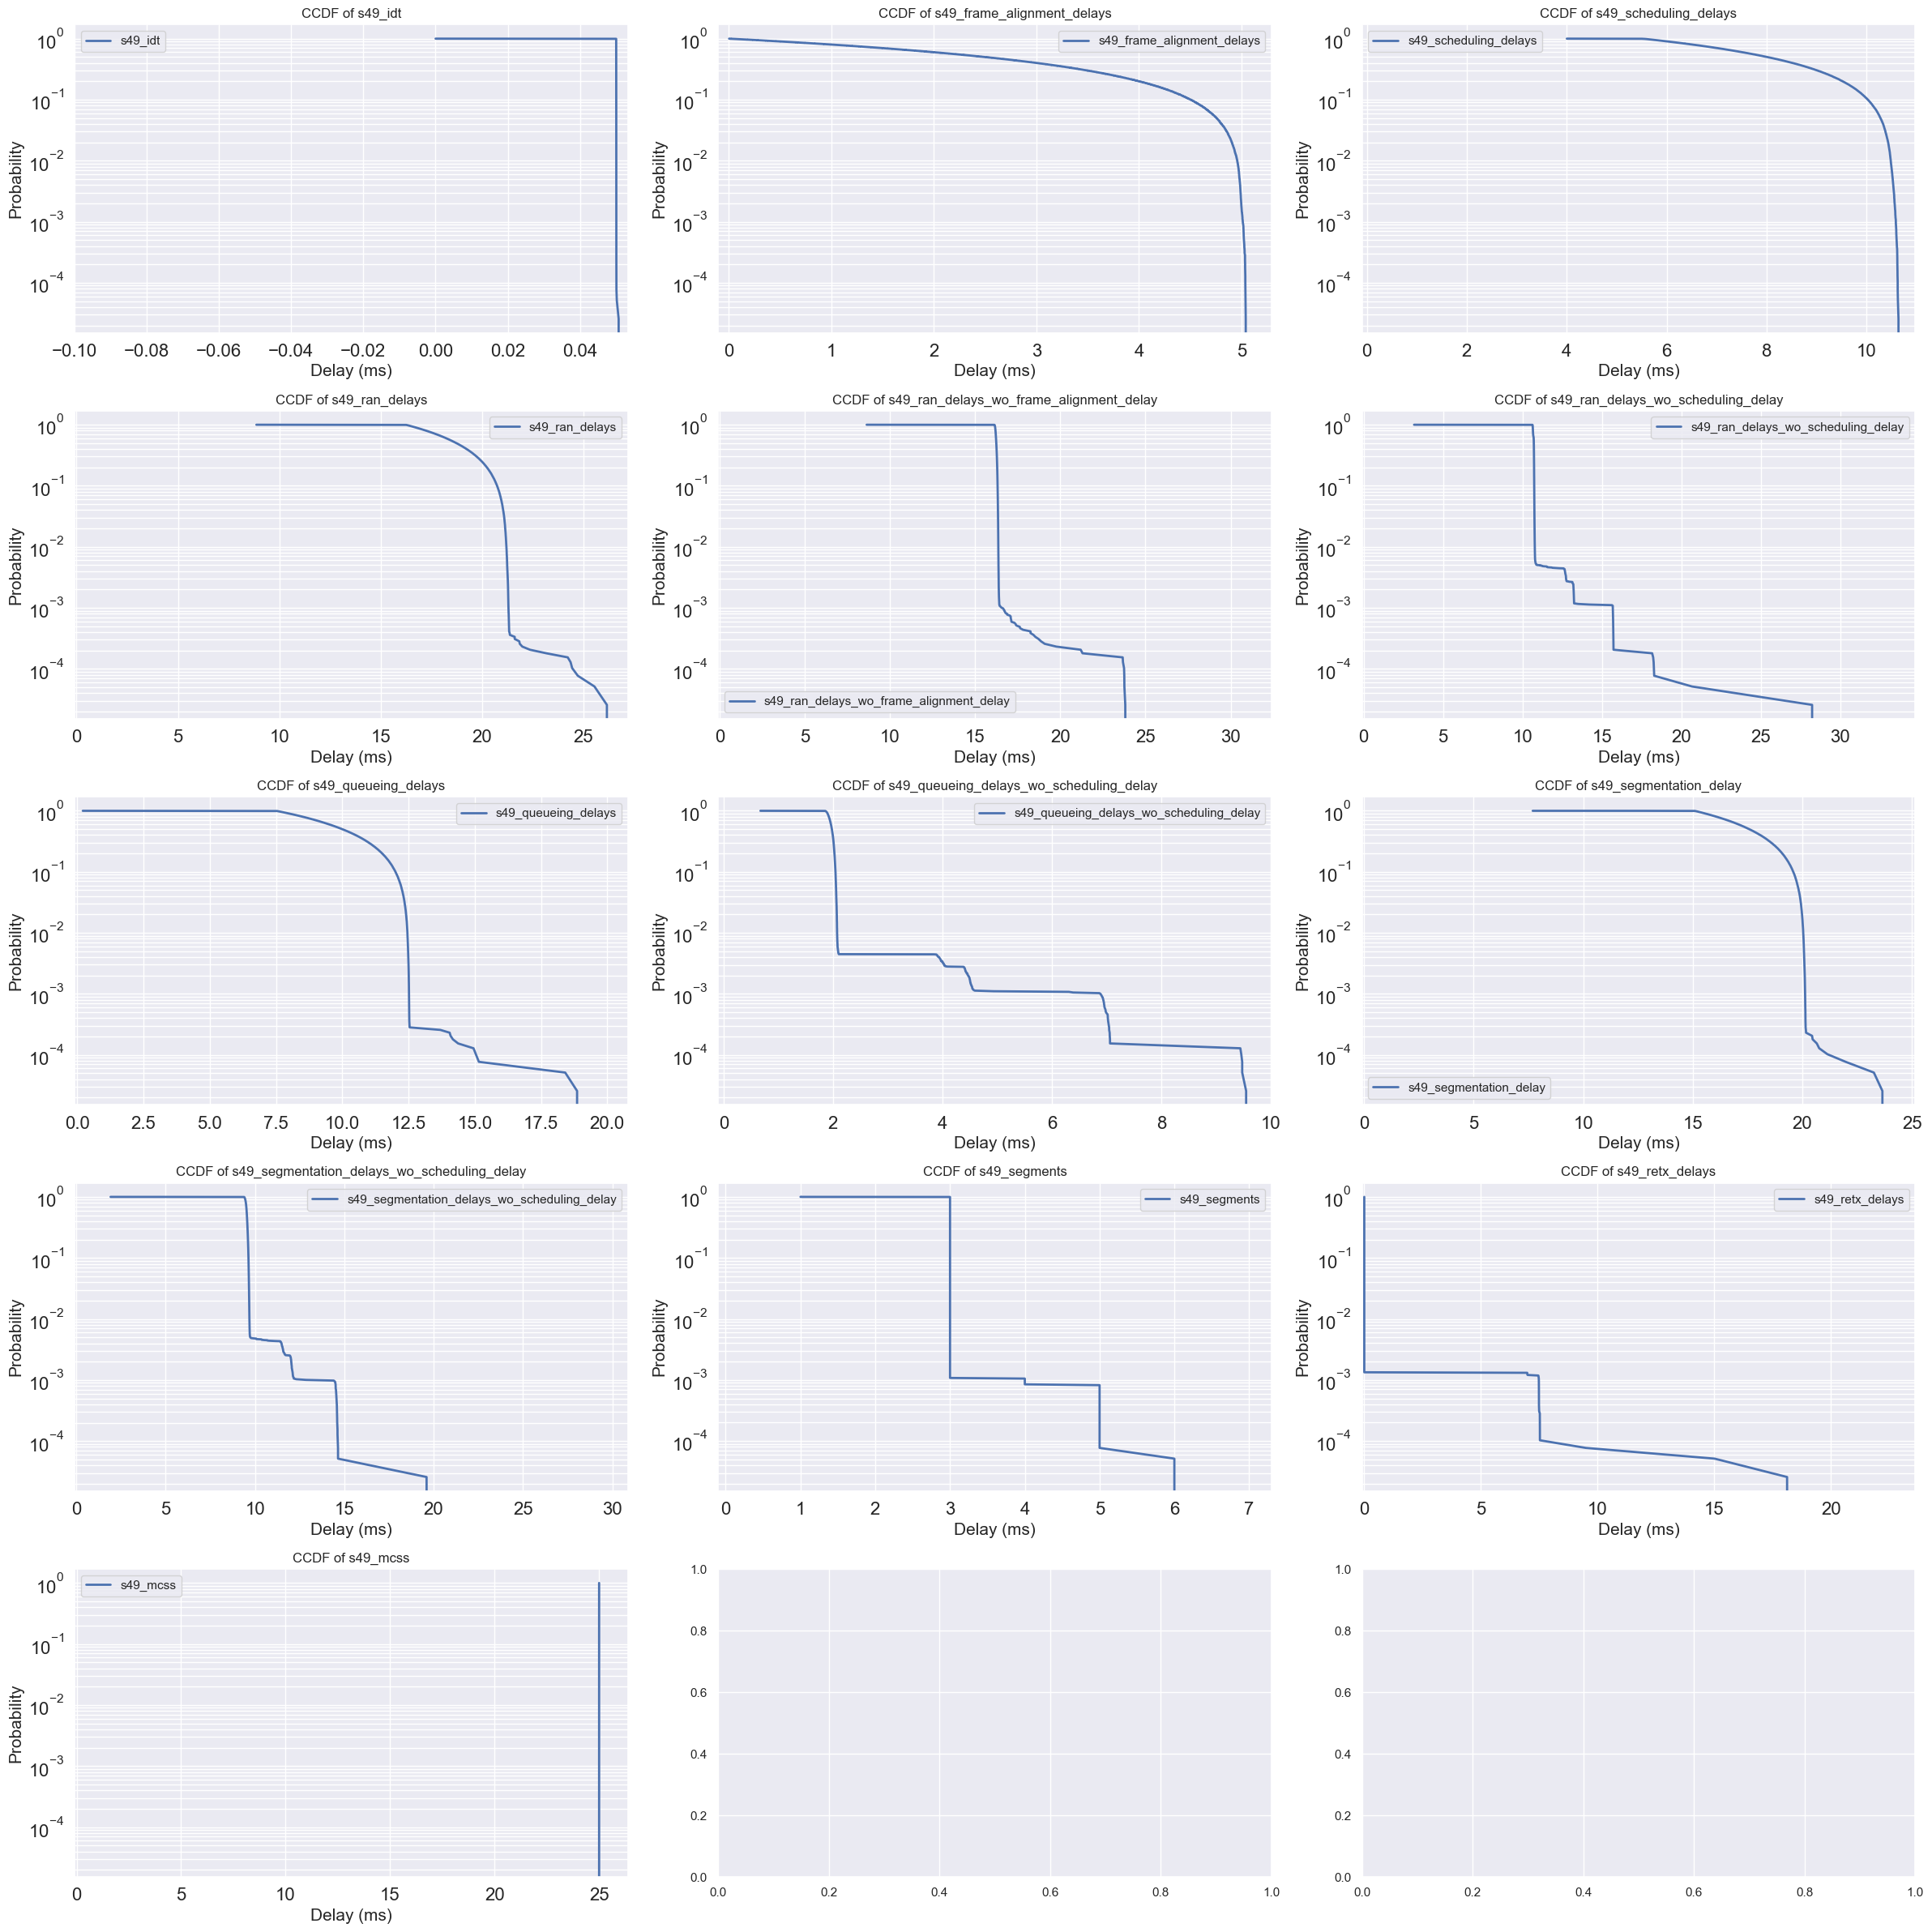

In [236]:
Meas_s49.plotAllCCDF(subplot_division=[5, 3])
# Meas_s49.plotAllCCDF(subplot_division=[1, 1])
# Meas_s49.plotAllCCDF(subplot_division=[1, 3])
# Meas_s49.plotAllCCDF(subplot_division=[3, 1])

#### 3.1.5 ```plotTimeSeries``` plot data values v.s. index

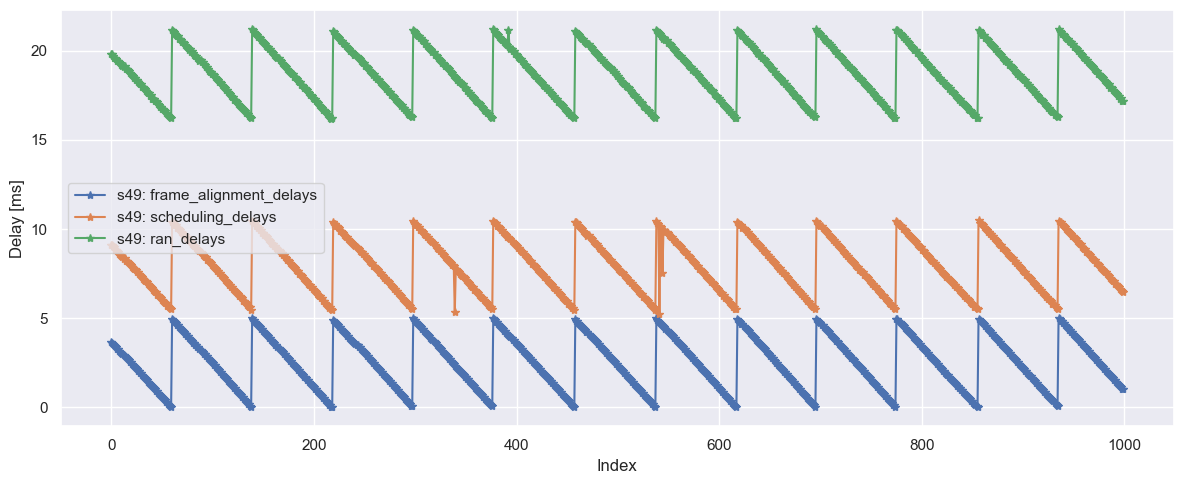

In [237]:
Meas_s49.plotTimeSeries(["frame_alignment_delays", "scheduling_delays", "ran_delays"])

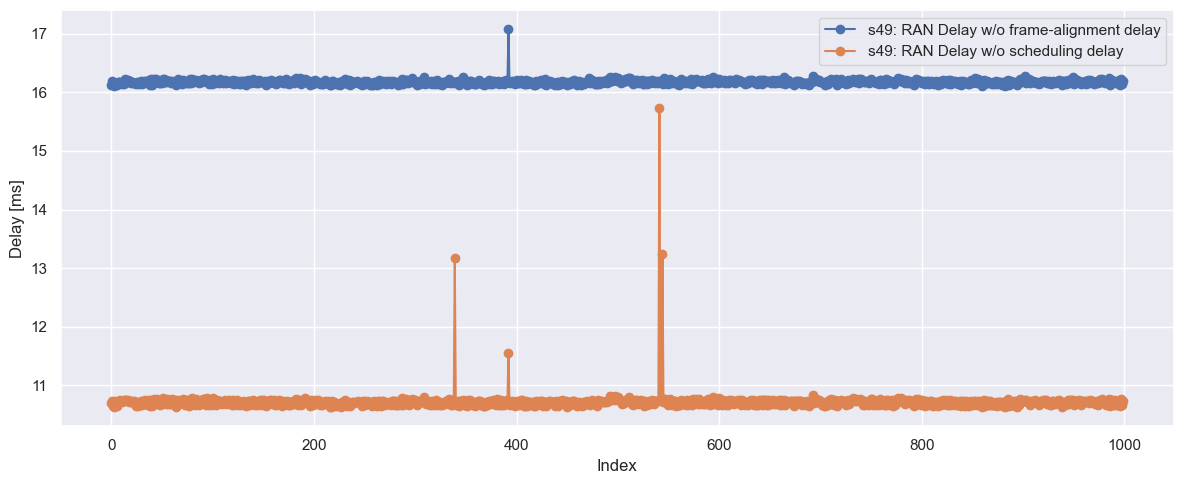

In [238]:
Meas_s49.plotTimeSeries(
    ["RAN Delay w/o frame-alignment delay", "RAN Delay w/o scheduling delay"],
    curves=[Meas_s49.delays.ran_delays-Meas_s49.delays.frame_alignment_delays, Meas_s49.delays.ran_delays-Meas_s49.delays.scheduling_delays],
    marker="o"
)

## 4 ```class MultiMeas``` for visualizing multiple datasets

In [247]:
class MultiMeas:
    def __init__(self, datasets_dir=DATASETS_DIR, meas_labels=["s39","s40","s49"]):
        """
        MultiMeas:
            save and visualize multiple Meas objects

        Parameters:
            datasets_dir(str): Path of all datasets;
            meas_label(list of str): The measurement label;
        """
        self.meas=[]
        self.meas_labels=meas_labels
        for meas_label in meas_labels:
            self.meas.append(Meas(datasets_dir=datasets_dir, meas_label=meas_label))
        self.folder_label="_".join(meas_labels)
        if not os.path.exists(PLOTS_DIR + self.folder_label):
            os.makedirs(PLOTS_DIR + self.folder_label)

    def plotCCDF(self, curve_names, meas_names, skip_first=SKIP_FIRST, skip_last=SKIP_LAST, figsize=(8,5), plt_show=True, ax_external=None, title='ccdf_plot'):
        """
        MultiMeas.plotCCDF:
            plot 1 ccdf among 13 kinds of delay measurement

        Parameters:
            curve_names(list of str):the delay measurement you want to plot
            meas_names(list of str):
            skip_first(int): skip first a few packets
            skip_last(int):  skip last a few packets
            figsize(tuple):  figsize
            plt_show(bool):  if or not show and save figure
            ax_external(object) ax object
            title(str): title (and filename)
        """
        if ax_external is None:
            _, ax=plt.subplots(figsize=figsize)
        else:
            ax=ax_external
        meas_list=[meas for meas in self.meas if meas.meas_label in meas_names]
        for one_meas in meas_list:
            for curve_name in curve_names:
                one_meas.plotCCDF(curve_name, skip_first=skip_first, skip_last=skip_last,ax_external=ax, plt_show=False)
        if plt_show:
            i = 1
            while os.path.exists(os.path.join(PLOTS_DIR, self.folder_label, f"{title}_{i}.png")):
                i += 1
            ax.set_title(f"{title}_{i}")
            plt.tight_layout()
            plt.savefig(
                f"{PLOTS_DIR}{self.folder_label}/{title}_{i}.png",
                dpi=300,
                bbox_inches="tight",
            )
            plt.show()

    def plotAllPerDelayType(self, figsize=(24,24),subplot_division=[1,1]):
        """
        Multieas.plotAllPerDelayType:
             plot CCDFs from multiple meas files on the same axes
        Parameters:
            figsize(tuple):  figsize
            subplot_division(list=[x,y]): x-row y-column subplots. If [1,1], figures will be plotted separately.
        """
        curve_names = [
            "idt",
            "frame_alignment_delays",
            "scheduling_delays",
            "ran_delays",
            "ran_delays_wo_frame_alignment_delay",
            "ran_delays_wo_scheduling_delay",
            "queueing_delays",
            "queueing_delays_wo_scheduling_delay",
            "segmentation_delay",
            "segmentation_delays_wo_scheduling_delay",
            "segments",
            "retx_delays",
            "mcss",
        ]
        figure_num=0
        for i in range(0,13):
            if i % (subplot_division[0]*subplot_division[1]) == 0:
                if i != 0:
                    plt.tight_layout()
                    plt.savefig(f"{PLOTS_DIR}{self.folder_label}/all_ccdf_plots_{figure_num}.png", dpi=300)
                    figure_num=figure_num+1
                    plt.show()
                _, axs = plt.subplots(subplot_division[0], subplot_division[1], figsize=figsize)

            if subplot_division[0]*subplot_division[1]==1:
                self.plotCCDF([curve_names[i]],self.meas_labels, plt_show=False, ax_external=axs)
            elif subplot_division[0]==1 or subplot_division[1]==1:
                self.plotCCDF([curve_names[i]],self.meas_labels, plt_show=False, ax_external=axs[i % (subplot_division[1]*subplot_division[0])])
            else:
                self.plotCCDF(
                    [curve_names[i]],
                    self.meas_labels,
                    plt_show=False,
                    ax_external=axs[
                        (
                            i
                            % (subplot_division[1] * subplot_division[0])
                            // subplot_division[1]
                        ),
                        i % subplot_division[1],
                    ],
                )
        plt.tight_layout()
        plt.savefig(f"{PLOTS_DIR}{self.folder_label}/all_ccdf_plots_{figure_num}.png", dpi=300, bbox_inches="tight")
        plt.show()

    def plotHistograms(self, delay_name, ax_external=None, skip_first=SKIP_FIRST, skip_last=SKIP_LAST, y_log=True, outlier=None, figsize=(8,5)):
        """
        Plots histograms for multiple arrays side by side on the same axes with normalized frequency.

        :param delay_name: The delay compoent to plot
        :param ax: Axes object to plot on
        :param skip_first: only take [skip_first:-skip_last] to plot
        :param skip_last:  only take [skip_first:-skip_last] to plot
        :param labels: List of labels for each array
        :param y_log: Boolean to set y-axis to log scale if True
        :param outlier: Cap value for outliers (optional)
        """

        values_per_meas = []
        labels = []
        for one_meas in self.meas:
            one_delay=getattr(one_meas.delays, delay_name, None)
            if one_delay is not None:
                values_per_meas.append(one_delay[skip_first:-skip_last])
                labels.append(one_meas.data.meas_label)
            else:
                print(f"No attribute {delay_name} found in meas.delays of {one_meas.data.meas_label}.")
        
        if ax_external is not None:
            ax=ax_external
        else:
            _, ax=plt.subplots(figsize=figsize)

        plot_multiple_histograms(values_per_meas=values_per_meas, ax=ax, labels=labels, y_log=y_log, delay_type_label=delay_name, outlier=outlier)
        plt.savefig(f"{PLOTS_DIR}{self.folder_label}/{delay_name}_hist_plot.png", dpi=300, bbox_inches="tight")
        plt.show()

    def plotTimeSeries(self, curve_names, meas_names, start_idx=2500, end_idx=2700, figsize=(12,5), marker="*", title="timeseries"):
        _, ax = plt.subplots(figsize=figsize)
        index_range = slice(start_idx, end_idx)

        meas_list=[meas for meas in self.meas if meas.meas_label in meas_names]
        for one_meas in meas_list:
            one_meas.plotTimeSeries(curve_names, start_idx=start_idx, end_idx=end_idx, figsize=figsize, marker=marker, ax_external=ax, plt_show=False)
        i = 0
        while os.path.exists(os.path.join(PLOTS_DIR, self.folder_label, f"{title}_{i}.png")):
            i += 1
        plt.tight_layout()
        plt.savefig(
            f"{PLOTS_DIR}{self.folder_label}/{title}_{i}.png", dpi=300, bbox_inches="tight"
        )
        plt.show()

### 4.1 Usage of ```class MultiMeas```

#### 4.1.1 Import datasets

In [248]:
Meas_s39_s40_s49=MultiMeas(meas_labels=["s39","s40","s49"])

RNTIs in packets of s39: ['dc46']
2024-11-13 13:20:12.757 | ERROR    | decomp:get_tx_delay:164 - Packet 16138 phy.in_t or phy.in_t not present
2024-11-13 13:20:12.758 | ERROR    | decomp:get_tx_delay:164 - Packet 16138 phy.in_t or phy.in_t not present
2024-11-13 13:20:12.948 | ERROR    | decomp:get_tx_delay:164 - Packet 10013 phy.in_t or phy.in_t not present
2024-11-13 13:20:12.948 | ERROR    | decomp:get_tx_delay:164 - Packet 10013 phy.in_t or phy.in_t not present
2024-11-13 13:20:13.499 | ERROR    | decomp:get_tx_delay:164 - Packet 16138 phy.in_t or phy.in_t not present
2024-11-13 13:20:13.507 | ERROR    | decomp:get_tx_delay:164 - Packet 16138 phy.in_t or phy.in_t not present
2024-11-13 13:20:13.749 | ERROR    | decomp:get_tx_delay:164 - Packet 10013 phy.in_t or phy.in_t not present
2024-11-13 13:20:13.749 | ERROR    | decomp:get_tx_delay:164 - Packet 10013 phy.in_t or phy.in_t not present
RNTIs in packets of s40: ['9afe']
RNTIs in packets of s49: ['5fcf']
2024-11-13 13:20:35.518 | 

In [249]:
print(Meas_s39_s40_s49.meas[0].data.meas_label)
print(Meas_s39_s40_s49.meas_labels)

s39
['s39', 's40', 's49']


#### 4.1.2 check Data 

In [250]:
Meas_s39_s40_s49.meas[0].checkData("packets")

{
    "sn": 0,
    "id": 21767,
    "len": 48,
    "ip.in_t": 1729237464.705833,
    "ip.out_t": 1729237464.729642,
    "rlc.in_t": 1729237464.70617,
    "rlc.out_t": 1729237464.729631,
    "backlog": 0,
    "rlc.attempts": [
        {
            "id": 0,
            "so": 0,
            "len": 16,
            "rep_acked": true,
            "resegment": [
                51.0,
                0.0,
                35.0,
                16.0
            ],
            "repeated": false,
            "mac.in_t": 1729237464.718527,
            "mac.out_t": 1729237464.719724,
            "rnti": "dc46",
            "frame": 896,
            "slot": 8,
            "acked": true,
            "mac.attempts": [
                {
                    "len": 24,
                    "id": 30,
                    "rnti": "dc46",
                    "frame": 896,
                    "slot": 8,
                    "hqpid": 13,
                    "phy.in_t": 1729237464.718531,
                    "phy

#### 4.1.3 ```plotCCDF``` plot CCDFs of certain delay components from certain datasets

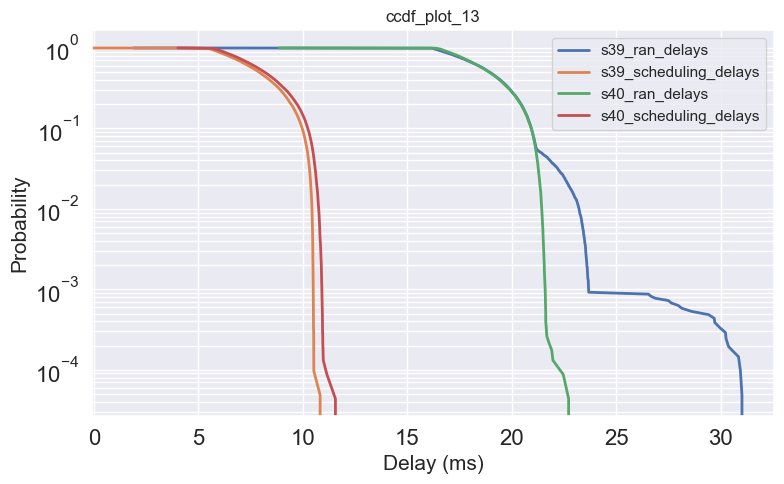

In [251]:
Meas_s39_s40_s49.plotCCDF(["ran_delays", "scheduling_delays"], ["s39", "s40"])

#### 4.1.4 ```plotAllPerDelayType```  plot CCDFs from multiple meas files on the same axes

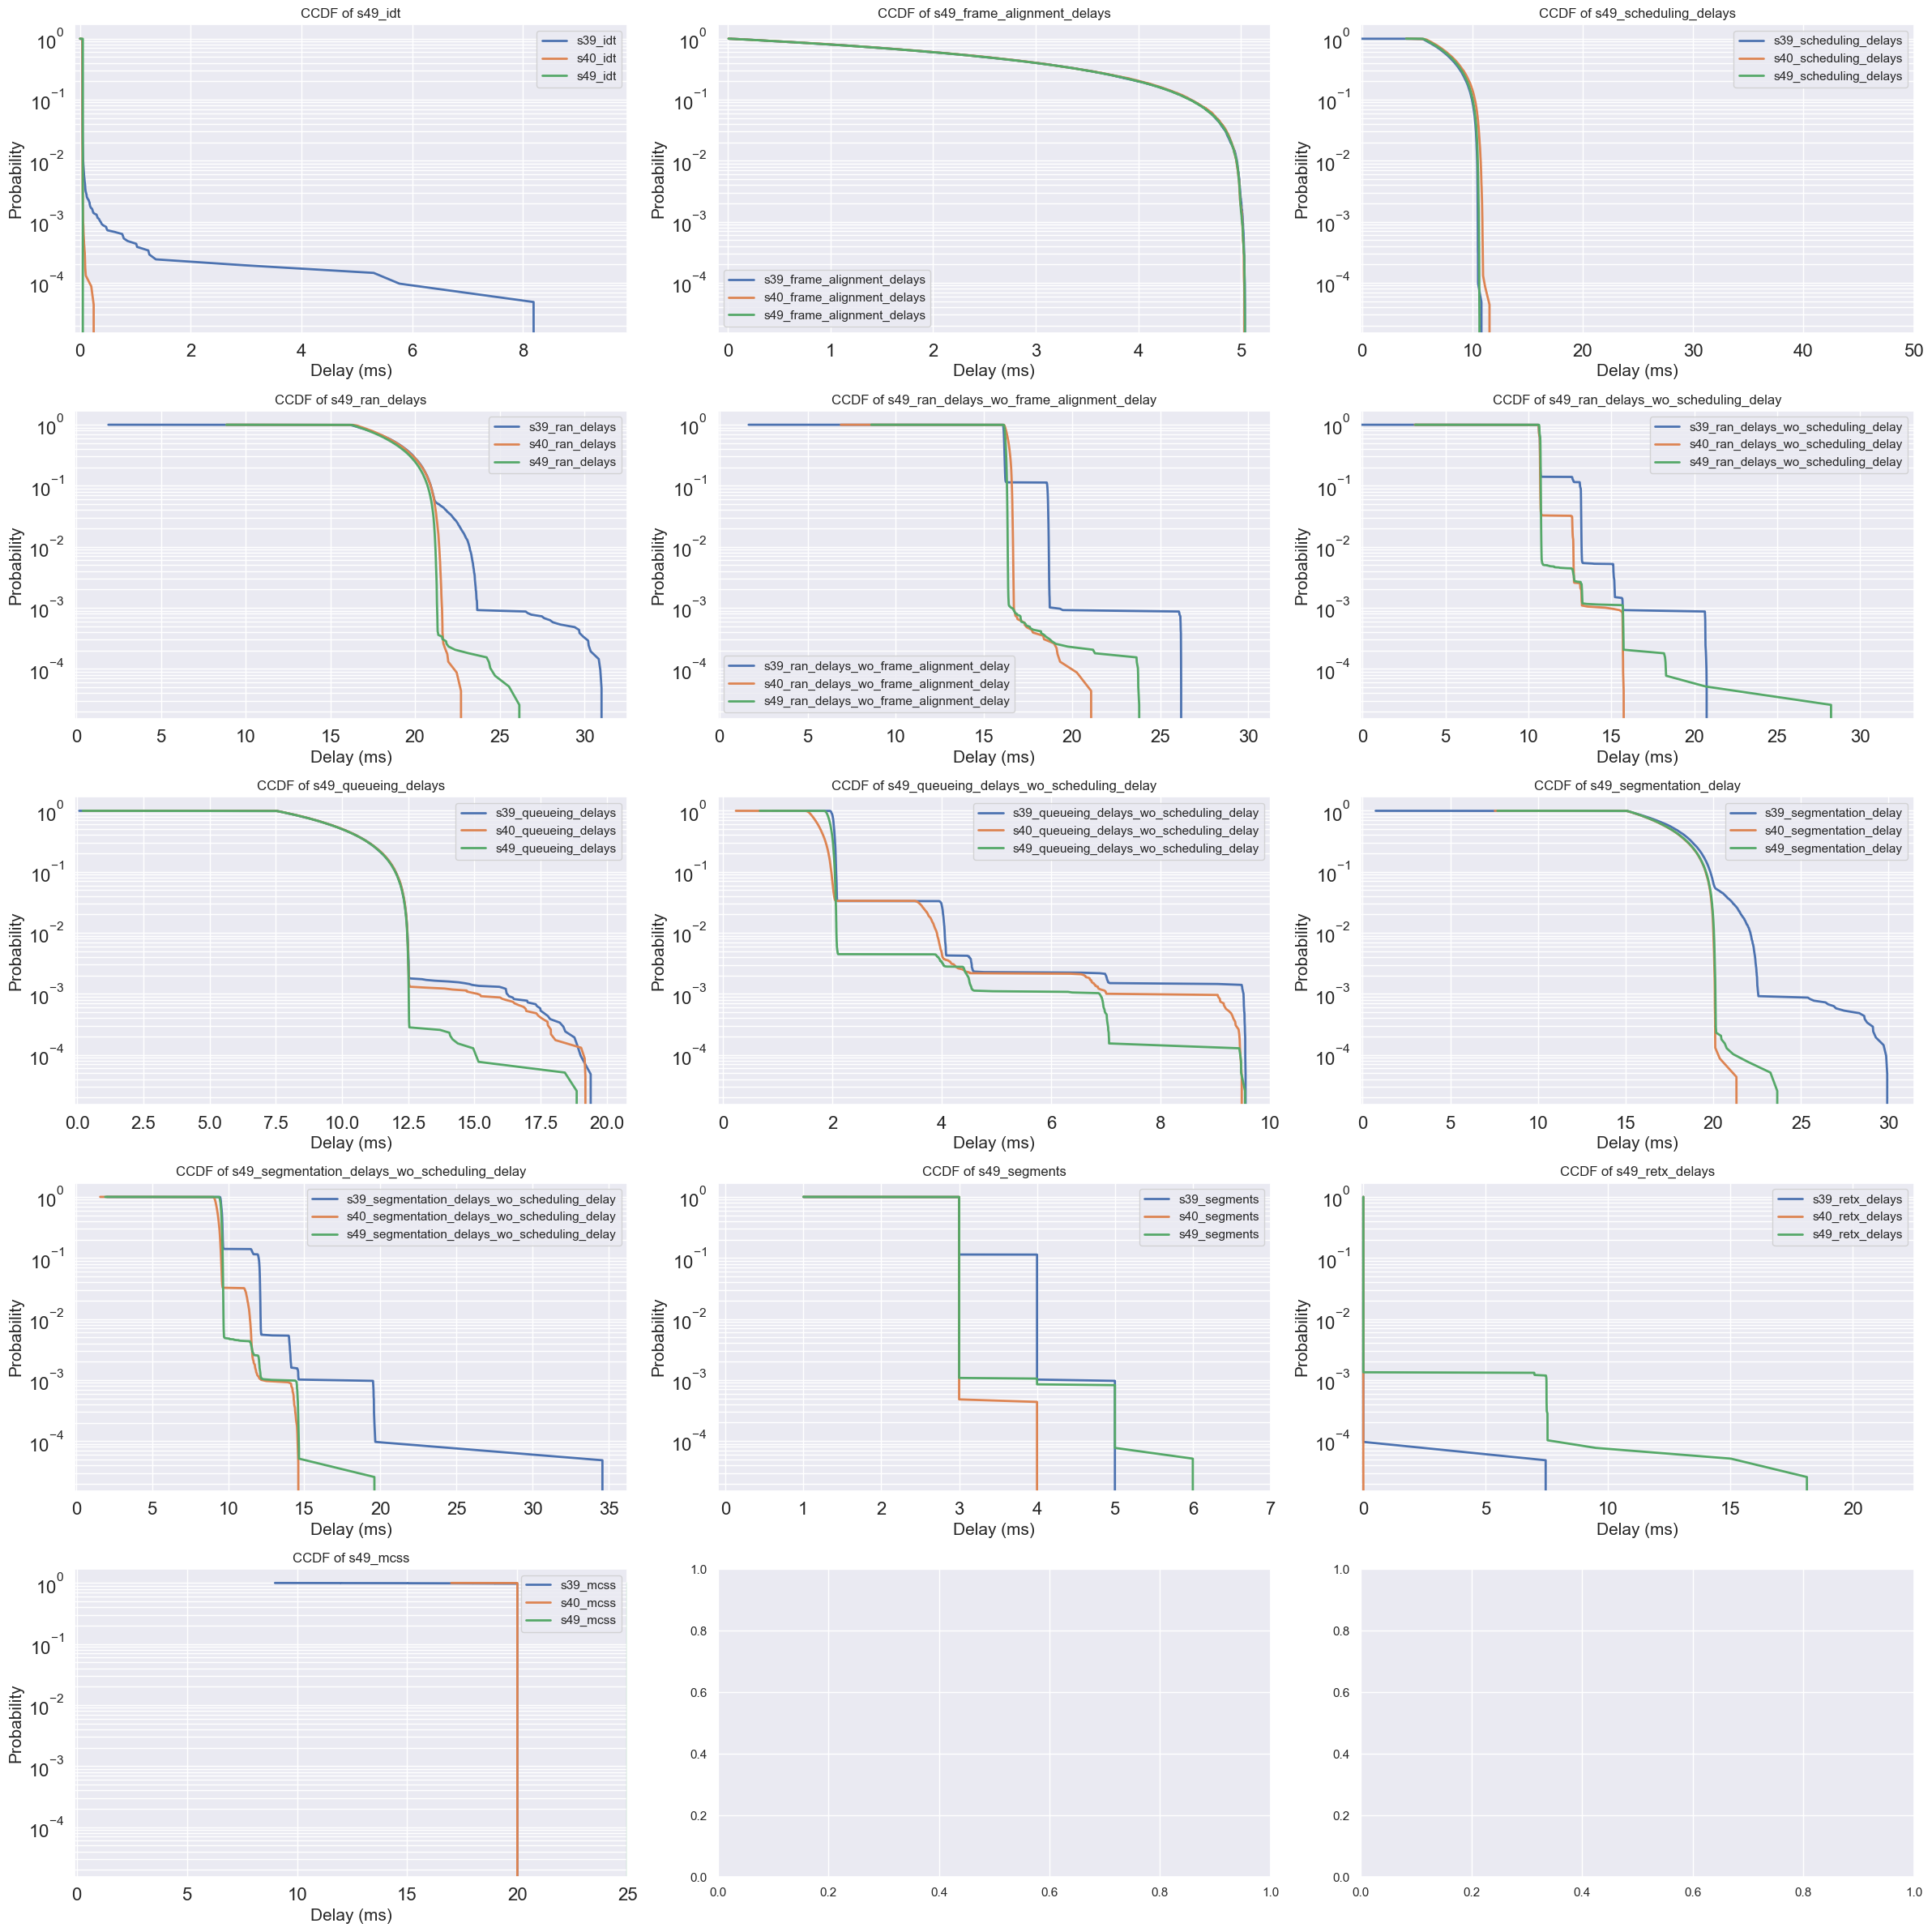

In [252]:
Meas_s39_s40_s49.plotAllPerDelayType(subplot_division=[5, 3])

#### 4.1.5 ```plotHistograms``` 
Plots histograms for multiple arrays side by side on the same axes with normalized frequency.

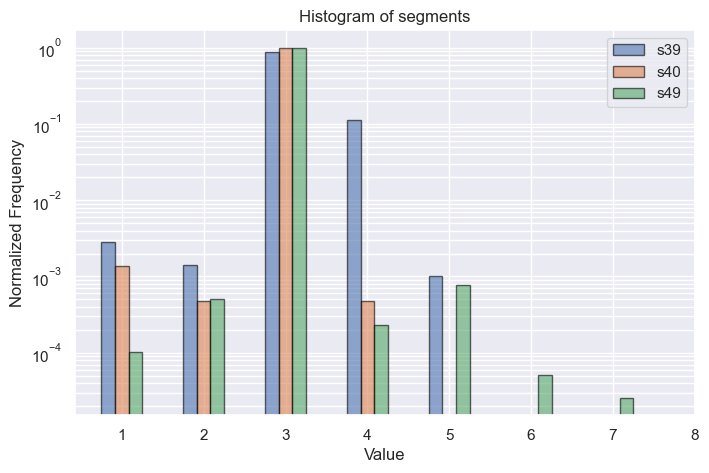

In [253]:
Meas_s39_s40_s49.plotHistograms("segments")

#### 4.1.6 ```plotTimeSeries```


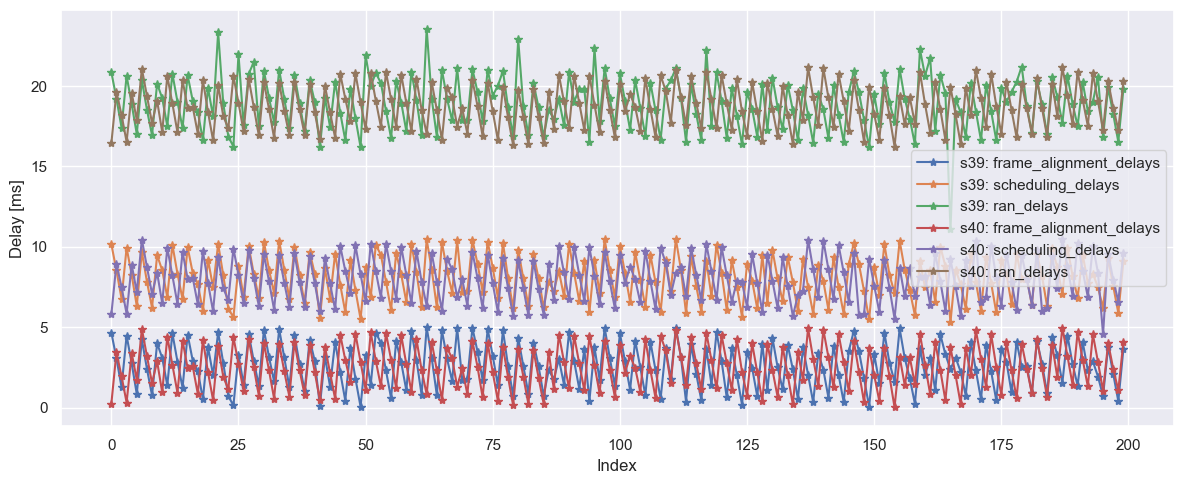

In [254]:
Meas_s39_s40_s49.plotTimeSeries(["frame_alignment_delays", "scheduling_delays","ran_delays"], ["s39", "s40"])